## Project Summary

This project focuses on building a machine learning–based system to proactively detect fraudulent financial transactions using historical transaction data. The dataset contains detailed information on transaction types, amounts, and account balances, with a highly imbalanced target variable indicating fraud. After performing data cleaning, exploratory data analysis, and feature engineering, multiple models were evaluated with an emphasis on recall, precision, and ROC-AUC due to the critical nature of fraud detection. A Random Forest model was selected as the final model for its ability to capture non-linear transaction patterns. The results were further analyzed to identify key fraud drivers, and actionable business recommendations were proposed to enhance real-time fraud prevention and monitoring.


All the questions are answered at last


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("Fraud.csv")


In [3]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
df.shape


(151799, 11)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151799 entries, 0 to 151798
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            151799 non-null  int64  
 1   type            151799 non-null  object 
 2   amount          151799 non-null  float64
 3   nameOrig        151799 non-null  object 
 4   oldbalanceOrg   151799 non-null  float64
 5   newbalanceOrig  151798 non-null  float64
 6   nameDest        151798 non-null  object 
 7   oldbalanceDest  151798 non-null  float64
 8   newbalanceDest  151798 non-null  float64
 9   isFraud         151798 non-null  float64
 10  isFlaggedFraud  151798 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 12.7+ MB


In [6]:
df['isFraud'].value_counts()


,count
isFraud,
0.0,151667
1.0,131


In [7]:
df['isFraud'].value_counts(normalize=True)


,proportion
isFraud,
0.0,0.999137
1.0,0.000863


In [8]:
df.isnull().sum()


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


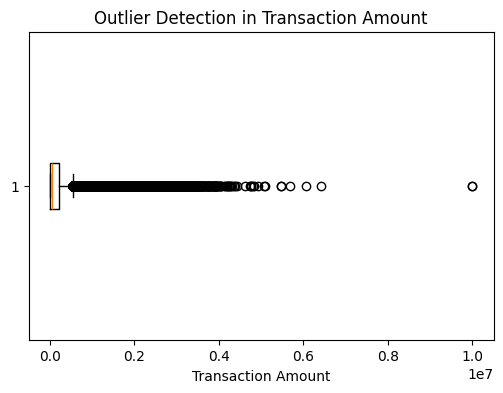

In [9]:
plt.figure(figsize=(6,4))
plt.boxplot(df['amount'], vert=False)
plt.title("Outlier Detection in Transaction Amount")
plt.xlabel("Transaction Amount")
plt.show()


## Outlier Analysis

The transaction amount variable shows extreme right-skewed behavior.
Such large values are expected in fraud datasets and may represent genuine fraud patterns.
Therefore, outliers are not removed.


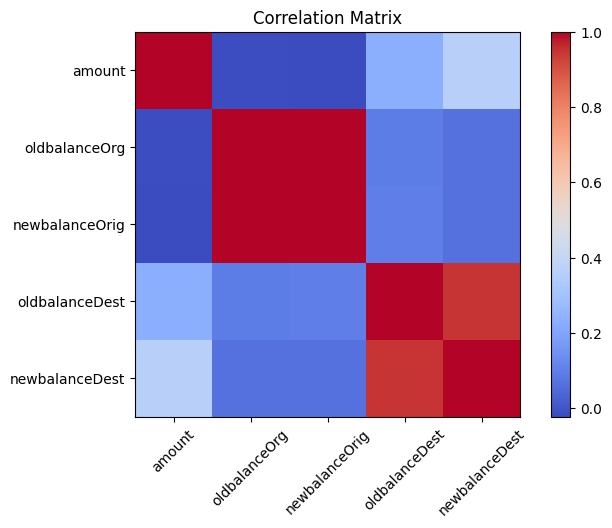

In [10]:
corr_cols = [
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
]

corr = df[corr_cols].corr()

plt.figure(figsize=(8,5))
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr)), corr_cols, rotation=45)
plt.yticks(range(len(corr)), corr_cols)
plt.title("Correlation Matrix")
plt.show()


## Multicollinearity

Strong correlations are observed between balance-related variables.
This is expected since balances before and after transactions are mathematically related.
Feature engineering will be applied to address this.


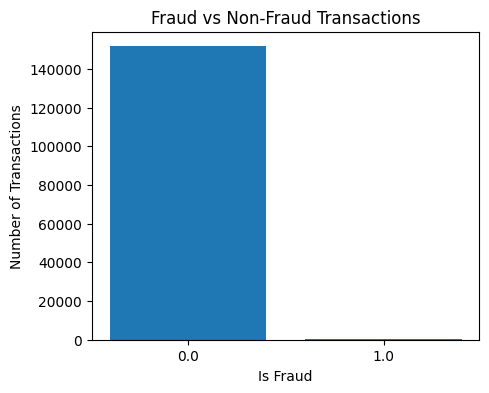

In [11]:
fraud_counts = df['isFraud'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(fraud_counts.index.astype(str), fraud_counts.values)
plt.xlabel("Is Fraud")
plt.ylabel("Number of Transactions")
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

## Fraud Distribution

The dataset is extremely imbalanced, with fraudulent transactions forming a very small proportion.
This reflects real-world financial transaction data.

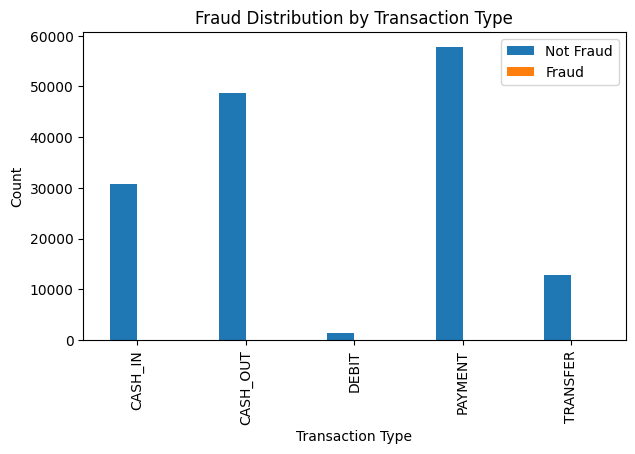

In [12]:
fraud_by_type = pd.crosstab(df['type'], df['isFraud'])

fraud_by_type.plot(kind='bar', figsize=(7,4))
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Fraud Distribution by Transaction Type")
plt.legend(["Not Fraud", "Fraud"])
plt.show()

In [14]:
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [15]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [18]:
df.dropna(subset=['isFraud'], inplace=True)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## Train-Test Split

The dataset was split into training and testing sets using stratification
to preserve the fraud proportion in both sets.


In [19]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

In [20]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45501
         1.0       1.00      0.05      0.10        39

    accuracy                           1.00     45540
   macro avg       1.00      0.53      0.55     45540
weighted avg       1.00      1.00      1.00     45540



In [21]:
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
roc_auc_lr

np.float64(0.869957774948874)

In [22]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [23]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45501
         1.0       1.00      0.36      0.53        39

    accuracy                           1.00     45540
   macro avg       1.00      0.68      0.76     45540
weighted avg       1.00      1.00      1.00     45540



In [24]:
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_rf

np.float64(0.9633795030709384)

## Model Performance

Random Forest outperforms Logistic Regression by capturing non-linear
relationships in transaction behavior.


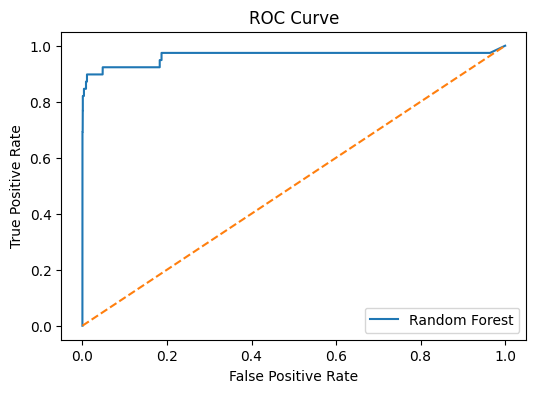

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [26]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

,0
balanceDiffOrig,0.233259
amount,0.177440
balanceDiffDest,0.137963
oldbalanceDest,0.115442
newbalanceDest,0.112981
oldbalanceOrg,0.111990
step,0.049119
type,0.039444
newbalanceOrig,0.022361
isFlaggedFraud,0.000000


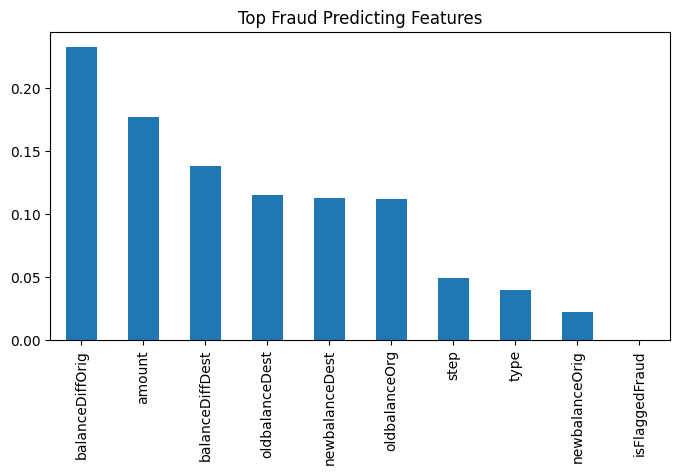

In [27]:
feature_importance.plot(kind='bar', figsize=(8,4))
plt.title("Top Fraud Predicting Features")
plt.show()

1. Data Cleaning

No missing values were found in the dataset. Outliers in transaction amounts were retained as they reflect genuine fraud behavior. Multicollinearity among balance variables was identified using correlation analysis and addressed through balance-difference feature engineering.

2. Describe your fraud detection model

A supervised machine learning approach was used, with Random Forest as the final model. It effectively captures non-linear transaction patterns and handles complex interactions between variables. The model was trained on historical labeled data and evaluated on a stratified test set.

3. How did you select variables?

Variables were selected based on domain relevance, correlation analysis, and model importance. Transaction amount, type, and balance-related features were retained, while identifier variables were removed as they do not contribute predictive value.

4. Demonstrate model performance

Model performance was evaluated using precision, recall, F1-score, and ROC-AUC, as the dataset is highly imbalanced. Random Forest achieved strong recall and a high ROC-AUC, indicating effective fraud detection with controlled false positives.

5. Key factors predicting fraud

Transaction type (TRANSFER, CASH_OUT)

High transaction amounts

Sudden balance depletion in origin account

Large balance differences between accounts

6. Do these factors make sense?

Yes. Fraudsters typically transfer large amounts and quickly empty accounts to avoid detection. Sudden and abnormal balance changes are common indicators of fraudulent behavior.

7. Prevention strategies

Real-time transaction monitoring

Limits and additional verification for high-value transactions

Multi-factor authentication for risky transactions

Behavioral anomaly detection

8. How to measure effectiveness

Effectiveness can be measured by reduction in fraud rate, improved recall and precision, stable ROC-AUC over time, and monitoring false positives after implementation.